In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt


In [6]:
df = pd.read_csv("../../data/space-track-gp/gp_20201214.csv.gz")

In [8]:

df = df.sort_values('PERIAPSIS')
len(df[df['PERIAPSIS'] < 0])

38

In [9]:
df['APOAPSIS'].describe()

count    4.588400e+04
mean     4.646403e+03
std      1.741404e+04
min     -1.418370e+02
25%      2.720140e+02
50%      5.743245e+02
75%      1.070893e+03
max      1.101767e+06
Name: APOAPSIS, dtype: float64

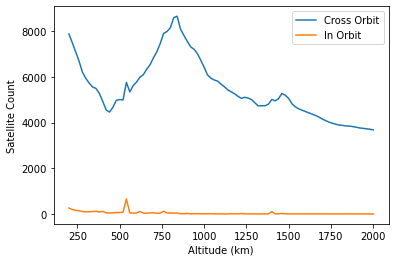

In [10]:
cross_counts = {}
tol_counts = {}
bin_size = 20
tolerance = 0

for alt in np.arange(200,2000+bin_size,bin_size):
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_counts[alt] = cross_count
    tol_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    tol_counts[alt] = tol_count
    

plt.figure()
x = cross_counts.keys()
y1 = cross_counts.values()
y2 = tol_counts.values()
plt.plot(x,y1, label='Cross Orbit')
plt.plot(x,y2, label='In Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Satellite Count")
plt.legend()
plt.show()

$Sphere Area = 4*\pi*r^2$

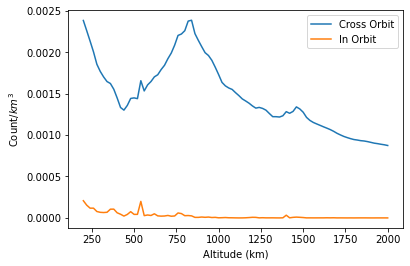

In [11]:
cross_density = {}
tol_density = {}
earth_radius = 6371
bin_size = 20
tolerance = 5


for alt in np.arange(200,2000+bin_size,bin_size):
    spatial_vol = 4*np.pi*(earth_radius+alt+bin_size)**2 - \
                  4*np.pi*(earth_radius+alt)**2
    cross_count = len(df[(df['PERIAPSIS'] <= alt+bin_size) & (df['APOAPSIS'] >= alt) & (df['PERIAPSIS'] > 0)])
    cross_density[alt] = cross_count / spatial_vol
    tol_count = len(df[(df['PERIAPSIS']>=alt-tolerance) & (df['APOAPSIS']<=alt+bin_size+tolerance)])
    tol_density[alt] = tol_count / spatial_vol

plt.figure()
x = cross_density.keys()
y1 = cross_density.values()
y2 = tol_density.values()
plt.plot(x,y1, label='Cross Orbit')
plt.plot(x,y2, label='In Orbit')
plt.xlabel("Altitude (km)")
plt.ylabel("Count/$km^3$")
plt.legend()
plt.show()